Processing Sensor 1: (56.44999999999999, -111.75000000000001)
Processing Sensor 2: (29.949999999999612, -111.05000000000005)
Processing Sensor 3: (53.449999999999946, -110.85000000000007)
Processing Sensor 4: (48.34999999999987, -111.45000000000003)
Processing Sensor 5: (-43.9500000000009, -111.85000000000001)

Universal Encoded Outputs:
   sensor_type  encoded_value       units  raw_value      range  resolution  \
0  temperature          0.683  normalized  18.252001  (-50, 50)           3   
1       u-wind          0.507  normalized   0.436000  (-30, 30)           3   
2       v-wind          0.553  normalized   3.169000  (-30, 30)           3   
3  temperature          0.676  normalized  17.636999  (-50, 50)           3   
4       u-wind          0.506  normalized   0.361000  (-30, 30)           3   

                            time  Sensor ID  
0  2016-04-30T00:00:00.000000000          1  
1  2016-04-30T00:00:00.000000000          1  
2  2016-04-30T00:00:00.000000000          1  
3

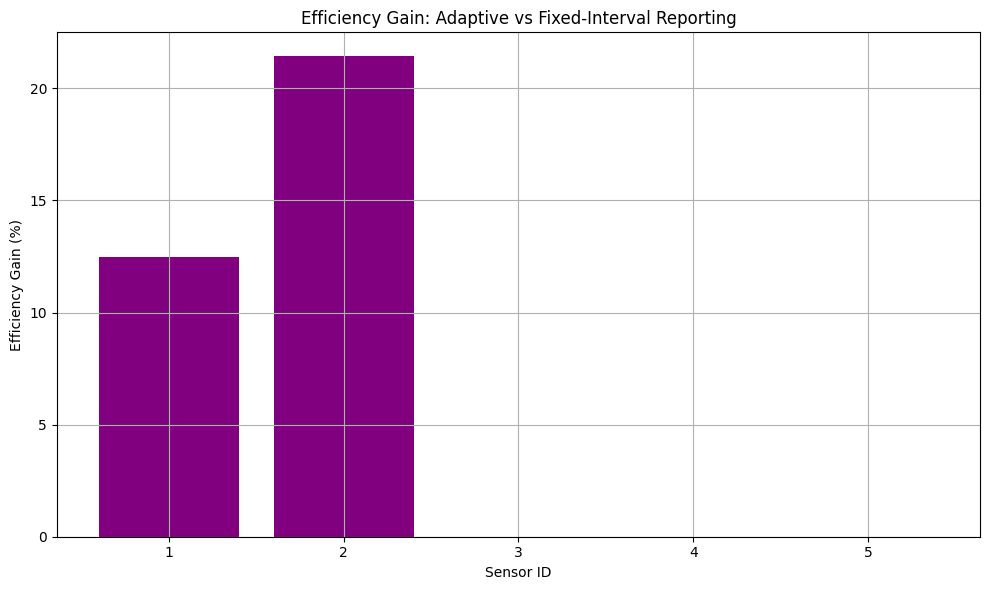

In [5]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from math import radians, cos, sin, sqrt, atan2

# Load the NetCDF data file
file_path = "../data/combined_era5_fort_mcmurray_temp_wind.nc"  # Adjust path as needed
ds = xr.open_dataset(file_path)

# Convert temperature to Celsius
ds["t2m_celsius"] = ds["t2m"] - 273.15

# Define the central hub location (average grid center)
central_lat, central_lon = ds["latitude"].mean().values, ds["longitude"].mean().values

# Haversine formula to compute distance between two latitude-longitude points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of Earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2.0) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2.0) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Adaptive reporting logic
def adaptive_reporting(temp):
    """Adaptive temperature reporting logic:
       - Fine granularity (1°C) below 20°C.
       - Coarser granularity (2°C) between 20°C and 30°C.
       - Logarithmic scale at extreme high temperatures (>30°C).
    """
    if temp < 20:
        return round(temp)  # Report to nearest 1°C
    elif 20 <= temp <= 30:
        return round(temp / 2) * 2  # Report to nearest 2°C
    elif temp > 30:
        return round(temp / 5) * 5  # Report to nearest 5°C
    return temp  # Fallback

# Universal Encoding Framework
def universal_encoder(sensor_type, value, min_range, max_range, precision=3):
    """
    Encodes a sensor value into a normalized symbolic representation.
    """
    # Normalize the value into [0, 1]
    normalized_value = round((value - min_range) / (max_range - min_range), precision)
    encoded_output = {
        "sensor_type": sensor_type,
        "encoded_value": normalized_value,
        "units": "normalized",
        "raw_value": round(value, precision),
        "range": (min_range, max_range),
        "resolution": precision
    }
    return encoded_output

# Function to simulate and encode n sensors
def simulate_and_encode_sensors(n_sensors):
    np.random.seed(42)  # Ensure repeatability
    
    # Randomly generate sensor locations
    latitudes = ds["latitude"].values
    longitudes = ds["longitude"].values
    sensor_locations = [(np.random.choice(latitudes), np.random.choice(longitudes)) for _ in range(n_sensors)]
    
    encoded_reports = []
    report_list = []
    
    for idx, (sensor_lat, sensor_lon) in enumerate(sensor_locations):
        print(f"Processing Sensor {idx + 1}: ({sensor_lat}, {sensor_lon})")
        
        # Extract sensor data (temperature, u-wind, v-wind)
        temp_data = ds["t2m_celsius"].sel(latitude=sensor_lat, longitude=sensor_lon).values
        u_wind_data = ds["u10"].sel(latitude=sensor_lat, longitude=sensor_lon).values
        v_wind_data = ds["v10"].sel(latitude=sensor_lat, longitude=sensor_lon).values
        valid_times = ds["valid_time"].values
        
        # Filter out NaN values for temperature
        filtered_temp_data = [temp for temp in temp_data if not np.isnan(temp)]
        
        # Encode sensor readings for all components
        for t, (temp, u_wind, v_wind) in enumerate(zip(temp_data, u_wind_data, v_wind_data)):
            if not np.isnan(temp):
                encoded_reports.append({
                    **universal_encoder("temperature", temp, min_range=-50, max_range=50),
                    "time": str(valid_times[t]),
                    "Sensor ID": idx + 1
                })
            if not np.isnan(u_wind):
                encoded_reports.append({
                    **universal_encoder("u-wind", u_wind, min_range=-30, max_range=30),
                    "time": str(valid_times[t]),
                    "Sensor ID": idx + 1
                })
            if not np.isnan(v_wind):
                encoded_reports.append({
                    **universal_encoder("v-wind", v_wind, min_range=-30, max_range=30),
                    "time": str(valid_times[t]),
                    "Sensor ID": idx + 1
                })
        
        # Adaptive and fixed reporting (only for temperature)
        adaptive_volume = len(set(adaptive_reporting(temp) for temp in filtered_temp_data)) * 4
        fixed_volume = len(set(round(temp) for temp in filtered_temp_data)) * 4
        
        # Distance and efficiency
        distance_to_hub = haversine(sensor_lat, sensor_lon, central_lat, central_lon)
        adaptive_efficiency = distance_to_hub / adaptive_volume if adaptive_volume > 0 else 0
        fixed_efficiency = distance_to_hub / fixed_volume if fixed_volume > 0 else 0
        
        report_list.append({
            "Sensor ID": idx + 1,
            "Latitude": sensor_lat,
            "Longitude": sensor_lon,
            "Adaptive Volume (Bytes)": adaptive_volume,
            "Fixed Volume (Bytes)": fixed_volume,
            "Efficiency Gain (%)": round((fixed_volume - adaptive_volume) / fixed_volume * 100, 2) if fixed_volume > 0 else 0,
            "Adaptive Efficiency (km/Byte)": round(adaptive_efficiency, 6),
            "Fixed Efficiency (km/Byte)": round(fixed_efficiency, 6)
        })
    
    # Return results
    encoded_df = pd.DataFrame(encoded_reports)
    summary_df = pd.DataFrame(report_list)
    return encoded_df, summary_df


# Run the simulation with universal encoding
n_sensors = 5
encoded_results, summary_report = simulate_and_encode_sensors(n_sensors)

# Display results
print("\nUniversal Encoded Outputs:")
print(encoded_results.head())

print("\nSensor Network Summary Report:")
print(summary_report)

# Plot Efficiency Gain
plt.figure(figsize=(10, 6))
plt.bar(summary_report["Sensor ID"], summary_report["Efficiency Gain (%)"], color="purple")
plt.title("Efficiency Gain: Adaptive vs Fixed-Interval Reporting")
plt.xlabel("Sensor ID")
plt.ylabel("Efficiency Gain (%)")
plt.grid()
plt.tight_layout()
plt.show()
